## Instalação das dependências

In [1]:
!pip install torch
!pip install espnet==0.9.5

## ESPNet

Os modelos deste trabalho foram treinados utilizando o [ESPNet](https://github.com/espnet/espnet)
.

ESPnet é um conjunto de ferramentas para processamento de fala fim-a-fim (E2E) focado principalmente em reconhecimento de fala e síntese de fala. O framework do ESPNet utilizado neste trabalho é o Pytorch.

Os experimentos podem ser reproduzidos com as configurações [deste](https://github.com/alucassch/espnet_ptbr) repositório, que segue o padrão de reprodução do ESPNet.

## Imports

In [1]:
import os
import io
import copy
import yaml
import torch
import shutil
import zipfile
import librosa
import numpy as np

from pathlib import Path
from os.path import abspath, join, exists, dirname, isfile, isdir
from typing import Tuple, Any, Dict, Union, TypeVar

#Importa os módulos do ESPNet necessários

from espnet2.tasks.asr import ASRTask
#ASRTask é a classe principal de uma tarefa de ASR (Automatic Speech Recognition)
#Carrega as informações para carregar um modelo a partir de um arquivo yaml
#o mesmo utilizado no treinamento

from espnet.nets.beam_search import BeamSearch
#Beam Search é o algoritmo de decodificação proposto pelos autores da ferramenta
#Chamado de joint decoding, para cada frame a hipotese é balanceada entre uma rede
#com CTC loss e uma rede de  atenção. A justificativa é que a rede CTC acelera o aprendizado
#do alinhamento da rede de atenção, principalmente Transformers, naturalmente difíceis de se treinar

from espnet.nets.scorers.ctc import CTCPrefixScorer
from espnet.nets.scorers.length_bonus import LengthBonus
#Inicialização e configuração do algoritmo de BeamSearch. 

from espnet2.text.build_tokenizer import build_tokenizer
from espnet2.text.token_id_converter import TokenIDConverter
#Métodos úteis para conversão de tokens usados pelo treinamento pelos caracteres ortográficos

from espnet2.main_funcs.calculate_all_attentions import calculate_all_attentions
#Método que executa um passo forward na rede de atenção e salva os valores das matrizes
#de atenção para os labels de saída. Útil para plotar o alinhamento dos modelos de atenção

from espnet2.torch_utils.device_funcs import to_device
#Útil

%matplotlib inline
import librosa.display
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import Image, display, Audio

from google_drive_downloader import GoogleDriveDownloader as gdd


# Modelos

In [2]:
#Dados para download dos arquivos de modelo
MODEL_TYPES = ["rnn", "convrnn", "transformer"]
model_type_d = {"rnn":"rnn", "convrnn":"vggrnn", "transformer":"transformer"}

TOKEN_TYPES = ["char", "subword"]
token_type_d = {'char': 'char', 'subword': 'bpe'}


MODELS_URLS = {
    "rnn_char" : "1c_J3MEEPQXhaYSYTMy-Pp6Wm7g4F3ppo",
    "vggrnn_char" : "12SAYVc8LMDEg9Hm5vcVnwIw_H1xqH8Dh",
    "transformer_char" : "1Sm_LZkna8RMCxWBCdoZwdPHecxJ5X24F",
    "rnn_bpe" : "18Ges8RBV5VOx1l7EuYUYrl4B7ikln4j-",
    "vggrnn_bpe" : "1A8sLkrP-Gl_BnQV0Nor5o46slmVHQE-t",
    "transformer_bpe" : "1EXhX_mvlZifFdxUXMlI4h-tTyqaJfZov"
}

In [24]:
#Função que faz o download do modelo escolhido
def download_model(model_type, token_type):
    fname = f"asr_train_commonvoice_{model_type}_raw_{token_type}_valid.acc.ave.zip"
    if not os.path.exists(fname):
        print(f"Downloading {fname}")
        gdd.download_file_from_google_drive(
            file_id=MODELS_URLS[f"{model_type}_{token_type}"],
            dest_path=f"./{fname}"
        )
    else:
        print(f"Model file {fname} exists")
    return fname


In [4]:
#Classe pra encapsular um resultado da inferência
class Result(object):
    def __init__(self) -> None:
        self.text = None
        self.tokens_txt = None
        self.tokens_int = None
        self.ctc_posteriors = None
        self.attention_weights = None
        self.encoded_vector = None
        self.audio_samples = None
        self.mel_features = None

#Classe para encapsular um modelo e fazer a inferência
class ASR(object):
    def __init__(
        self, 
        zip_model_file: Union[Path, str],
    ) -> None:
        
        self.zip_model_file = abspath(zip_model_file)
        self.device = 'cpu'
        self.model = None
        self.beam_search = None
        self.tokenizer = None
        self.converter = None
        self.global_cmvn = None
        self.extract_zip_model_file(self.zip_model_file)
        
    def extract_zip_model_file(self, zip_model_file: str) -> Dict[str, Any]:
      """Extrai os dados de um zip contendo o arquivo com o estado do modelo e configurações

      Args:
          zip_model_file (str): ZipFile do modelo gerado dos scripts de treinamento

      Raises:
          ValueError: Se o arquivo não for correto
          FileNotFoundError: Se o arquivo zip não contiver os arquivos necessários

      Returns:
          Dict[str, Any]: Dicionário do arquivo .yaml utilizado durante o treinamento para carregar o modelo corretamente
      """
      print("Unzipping model")
      if not zipfile.is_zipfile(zip_model_file):
          raise ValueError(f"File {zip_model_file} is not a zipfile")
      else:
          zipfile.ZipFile(zip_model_file).extractall(dirname(zip_model_file))

      check = ['exp', 'meta.yaml']

      if not all([x for x in check]):
          raise FileNotFoundError
      
      print("Load yaml file")
      with open('meta.yaml') as f:
          meta = yaml.load(f, Loader=yaml.FullLoader)

      model_stats_file = meta['files']['asr_model_file']
      asr_model_config_file = meta['yaml_files']['asr_train_config']
      
      self.model_config = {}
      with open(asr_model_config_file) as f:
          self.model_config = yaml.load(f, Loader=yaml.FullLoader)
          try:
              self.global_cmvn = self.model_config['normalize_conf']['stats_file']
          except KeyError:
              self.global_cmvn = None

      print(f'Loading model config from {asr_model_config_file}')
      print(f'Loading model state from {model_stats_file}')

      #Build Model
      print('Building model')
      self.model, _ = ASRTask.build_model_from_file(
          asr_model_config_file, model_stats_file, self.device
      )
      self.model.to(dtype=getattr(torch, 'float32')).eval()
      
      #print("Loading extra modules")
      self.build_beam_search()
      self.build_tokenizer()

    def build_beam_search(self, ctc_weight: float = 0.4, beam_size: int = 1):
        """Constroi o objeto de decodificação beam_search.

        Esse objeto faz a decodificação do vetor de embeddings da saída da parte encoder
        do modelo passando pelos decoders da rede que são o módulo CTC e Transformer ou RNN.

        Como:
        Loss = (1-λ)*DecoderLoss + λ*CTCLoss 
        Se ctc_weight=1 apenas o módulo CTC será usado na decodificação

        Args:
            ctc_weight (float, optional): Peso dado ao módulo CTC da rede. Defaults to 0.4.
            beam_size (int, optional): Tamanho do feixe de busca durante a codificação. Defaults to 1.
        """
        scorers = {}
        ctc = CTCPrefixScorer(ctc=self.model.ctc, eos=self.model.eos)
        token_list = self.model.token_list
        scorers.update(
            decoder=self.model.decoder,
            ctc=ctc,
            length_bonus=LengthBonus(len(token_list)),
        )

        #Variáveis com os pesos para cada parte da decodificação
        #lm referente à modelos de linguagem não são utilizados aqui mas são necessários no objeto
        weights = dict(
            decoder=1.0 - ctc_weight,
            ctc=ctc_weight,
            lm=1.0,
            length_bonus=0.0,
        )

        #Cria o objeto beam_search
        self.beam_search = BeamSearch(
            beam_size=beam_size,
            weights=weights,
            scorers=scorers,
            sos=self.model.sos,
            eos=self.model.eos,
            vocab_size=len(token_list),
            token_list=token_list,
            pre_beam_score_key=None if ctc_weight == 1.0 else "full",
        )

        self.beam_search.to(device=self.device, dtype=getattr(torch, 'float32')).eval()
        for scorer in scorers.values():
            if isinstance(scorer, torch.nn.Module):
                scorer.to(device=self.device, dtype=getattr(torch, 'float32')).eval()

    def build_tokenizer(self):
        """Cria um objeto tokenizer para conversão dos tokens inteiros para o dicionário
        de caracteres correspondente.

        Caso o modelo possua um modelo BPE de tokenização, ele é utilizado. Se não, apenas a lista
        de caracteres no arquivo de configuração é usada.
        """
        token_type = self.model_config['token_type']
        if token_type == 'bpe':
            bpemodel = self.model_config['bpemodel']
            self.tokenizer = build_tokenizer(token_type=token_type, bpemodel=bpemodel)
        else:
            self.tokenizer = build_tokenizer(token_type=token_type)
        
        self.converter = TokenIDConverter(token_list=self.model.token_list)

    def get_layers(self) -> Dict[str, Dict[str, torch.Size]]:
        """Retorna as camadas nomeadas e os respectivos shapes para todos os módulos da rede.

        Os módulos são:
            Encoder: RNN, VGGRNN, TransformerEncoder
            Decoder: RNN, TransformerDecoder
            CTC

        Returns:
            Dict[str, Dict[str, torch.Size]]: Dicionário de cada módulo com seus respectivos layers e shape
        """
        r = {}

        r['frontend'] = {x: self.model.frontend.state_dict()[x].shape 
                            for x in self.model.frontend.state_dict().keys()}
        r['specaug'] = {x: self.model.specaug.state_dict()[x].shape 
                            for x in self.model.specaug.state_dict().keys()}
        r['normalize'] = {x: self.model.normalize.state_dict()[x].shape 
                            for x in self.model.normalize.state_dict().keys()}
        r['encoder'] = {x: self.model.encoder.state_dict()[x].shape 
                            for x in self.model.encoder.state_dict().keys()}
        r['decoder'] = {x: self.model.decoder.state_dict()[x].shape 
                            for x in self.model.decoder.state_dict().keys()}
        r['ctc']     = {x: self.model.ctc.state_dict()[x].shape 
                            for x in self.model.ctc.state_dict().keys()}
        return r

    def frontend(self, audiofile: Union[Path, str, bytes], normalize: bool = True) -> Tuple[torch.Tensor, torch.Tensor]:
        """Executa o frontend do modelo, transformando as amostras de áudio em parâmetros log mel spectrogram

        Args:
            audiofile (Union[Path, str]): arquivo de áudio

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Parâmetros, Tamanho do vetor de parâmetros
        """
        if isinstance(audiofile, str):
            audio_samples, rate = librosa.load(audiofile, sr=16000)
        elif isinstance(audiofile, bytes):
            audio_samples, rate = librosa.core.load(io.BytesIO(audiofile), sr=16000)
        else:
            raise ValueError("Failed to load audio file")
            
        if isinstance(audio_samples, np.ndarray):
            audio_samples = torch.tensor(audio_samples)
        audio_samples = audio_samples.unsqueeze(0).to(getattr(torch, 'float32'))
        lengths = audio_samples.new_full([1], dtype=torch.long, fill_value=audio_samples.size(1))
        features, features_length  = self.model.frontend(audio_samples, lengths)

        if normalize:
            features, features_length = self.model.normalize(features, features_length)

        return features, features_length

    def specaug(self, features: torch.Tensor, features_length: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Executa o módulo specaug, da parte de 'data augmentation'.
        Útil para visualização apenas. 
        Não é utilizado na inferência, apenas no treinamento.

        Args:
            features (torch.Tensor): Parâmetros
            features_length (torch.Tensor): tamanho do vetor de parâmetros

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Parâmetros com máscaras temporais, em frequência e distoção. Tamanho dos vetores
        """
        return self.model.specaug(features, features_length)

    def __del__(self) -> None:
        """Remove os arquivos temporários
        """
        for f in ['exp', 'meta.yaml']:
            print(f"Removing {f}")
            ff = join(dirname(self.zip_model_file), f)
            if exists(ff):
                if isdir(ff):
                    shutil.rmtree(ff)
                elif isfile(ff):
                    os.remove(ff)
                else:
                    raise ValueError("Error ao remover arquivos temporários")
            

    @torch.no_grad()
    def recognize(self, audiofile: Union[Path, str, bytes]) -> Result:
        """Faza inferência no áudio, retorna um objeto da classe Result
        """
        result = Result()
        
        if isinstance(audiofile, str):
            audio_samples, rate = librosa.load(audiofile, sr=16000)
        elif isinstance(audiofile, bytes):
            audio_samples, rate = librosa.core.load(io.BytesIO(audiofile), sr=16000)
        else:
            raise ValueError("Failed to load audio file")

        result.audio_samples = copy.deepcopy(audio_samples)

        #a entrada do modelo é torch.tensor
        if isinstance(audio_samples, np.ndarray):
            audio_samples = torch.tensor(audio_samples)
        audio_samples = audio_samples.unsqueeze(0).to(getattr(torch, 'float32'))
        
        lengths = audio_samples.new_full([1], dtype=torch.long, fill_value=audio_samples.size(1))
        batch = {"speech": audio_samples, "speech_lengths": lengths}
        batch = to_device(batch, device=self.device)

        #model encoder
        enc, _ = self.model.encode(**batch)

        #model joint ctc/attention decoder
        nbest_hyps = self.beam_search(x=enc[0])

        #Apenas a melhor hipótese
        best_hyps = nbest_hyps[0]

        #Conversão de tokenids do treinamento para texto
        token_int = best_hyps.yseq[1:-1].tolist()
        token_int = list(filter(lambda x: x != 0, token_int))
        token = self.converter.ids2tokens(token_int)
        text = self.tokenizer.tokens2text(token)

        #Preenche o objeto result
        result.text = text
        result.encoded_vector = enc[0] #[0] remove dimensão de batch
        
        #calcula todas as matrizes de atenção
        text_tensor = torch.Tensor(token_int).unsqueeze(0).to(getattr(torch, 'long'))
        batch["text"] = text_tensor
        batch["text_lengths"] = text_tensor.new_full([1], dtype=torch.long, fill_value=text_tensor.size(1))
        result.attention_weights = calculate_all_attentions(self.model, batch)
        
        result.tokens_txt = token

        #CTC posteriors
        logp = self.model.ctc.log_softmax(enc.unsqueeze(0))[0]
        result.ctc_posteriors = logp.exp_().numpy()
        result.tokens_int = best_hyps.yseq
        result.mel_features, _ = self.frontend(audiofile, normalize=False)
        return result

    def __call__(self, input: Union[Path, str, bytes]) -> Result:
        return self.recognize(input)

asr = None

## Escolha um tipo de modelo

In [5]:
w1 = widgets.RadioButtons(
    options=MODEL_TYPES,
    value='rnn', 
    description='Model type:',
    disabled=False
)
display(w1)

RadioButtons(description='Model type:', options=('rnn', 'convrnn', 'transformer'), value='rnn')

## Escolha um formato dos símbolos $Y$


In [6]:
w2 = widgets.RadioButtons(
    options=TOKEN_TYPES,
    value='char',
    description='Token type:',
    disabled=False
)
display(w2)

RadioButtons(description='Token type:', options=('char', 'subword'), value='char')

## Faça o upload de um arquivo de áudio para inferência (wav, 16kHz)


In [7]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

## Execute a célula abaixo para carregar o modelo selecionado e realizar a inferência do áudio

É possível alterar os modelos nos diálogos acima e executar apenas as células abaixo para fazer uma nova inferência em um novo modelo e ter as visualizações.

Em caso da mensagem: TypeError: cannot perform reduce with flexible type

A solução é reiniciar o kernel do notebook

In [8]:
if isinstance(asr, ASR):
    del asr
    asr = None

model_type = model_type_d[w1.value]
token_type = token_type_d[w2.value]
try: 
    audio_file = uploader.value[list(uploader.value.keys())[0]]['content']
except IndexError:
    raise ValueError("Faça o upload de um arquivo de áudio")

asr_tag = "asr_train_commonvoice_"+model_type+"_raw_"+token_type

#Faz o downlooad do modelo caso o arquivo ainda não exista
model_file = download_model(model_type, token_type)

#Unzip do arquivo do modelo no diretório local e carregamento do objeto da classe ASR
#A classe ASR encapsula um modelo ESPNet em asr.model
asr = ASR(model_file)


#O método recognize recebe um arquivo de áudio ou um buffer de memória e fornece a melhor hipotese do modelo
results = asr.recognize(audio_file)

print(f"\nHipotese: {results.text}")


Model file asr_train_commonvoice_rnn_raw_char_valid.acc.ave.zip exists
Unzipping model
Load yaml file
Loading model config from exp/asr_train_commonvoice_rnn_raw_char/config.yaml
Loading model state from exp/asr_train_commonvoice_rnn_raw_char/valid.acc.ave_5best.pth
Building model


/home/aluca/espnet_ptbr/tools/venv/envs/venv/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729141890/work/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/aluca/espnet_ptbr/tools/venv/envs/venv/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729141890/work/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)



Hipotese: pesquisa é uma coisa que muda toda a hora


## Inferência

Hypotese: pesquisa é uma coisa que muda toda a hora


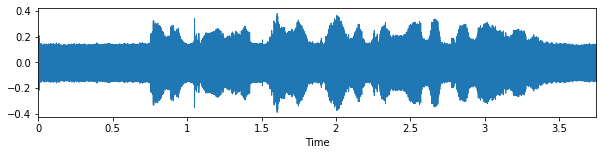

In [9]:
#Audio
plt.figure(figsize=(10, 2))
librosa.display.waveplot(results.audio_samples, sr=16000)
print(f"Hypotese: {results.text}")
Audio(audio_file)

### Arquitetura da rede completa

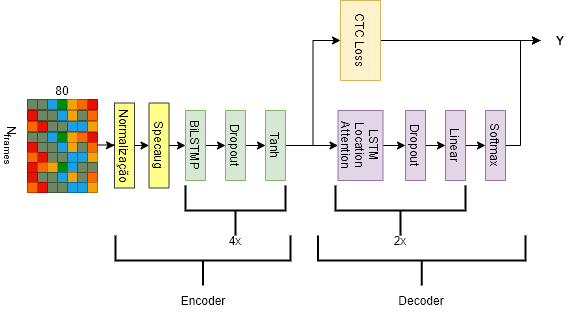

In [10]:
Image(f'imagens/{model_type}.png')

### Arquitetura da rede CTC

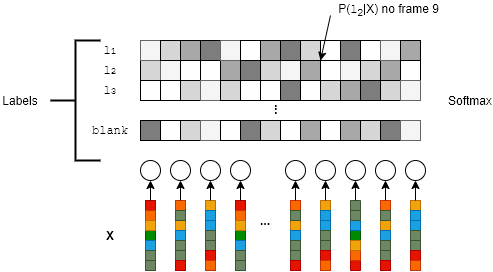

In [11]:
Image(f'imagens/ctc.png')

### Acurácia de treinamento e validação 

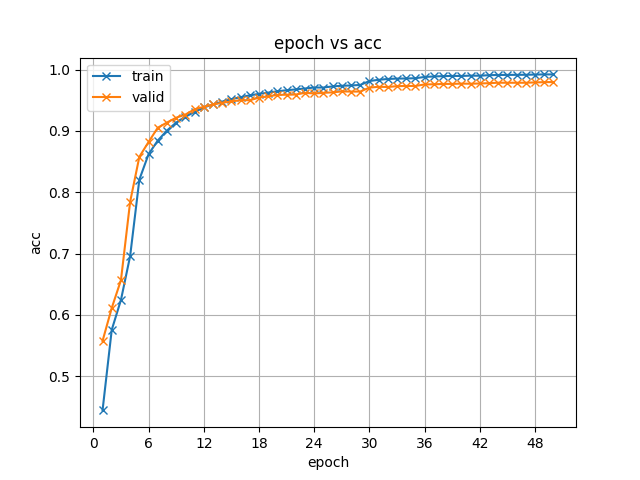

In [12]:
Image(f'exp/{asr_tag}/images/acc.png')

### Função custo do modelo de atenção

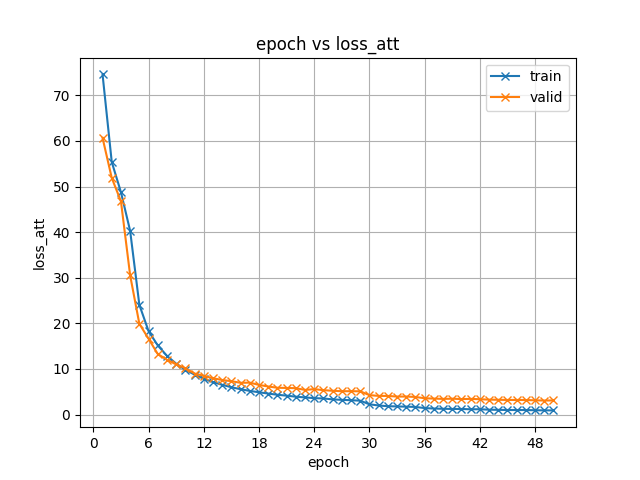

In [13]:
Image(f'exp/{asr_tag}/images/loss_att.png')

### Função custo  do modelo CTC

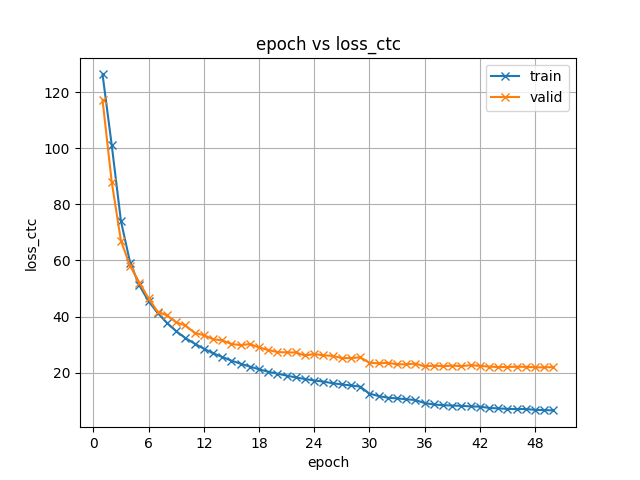

In [14]:
Image(f'exp/{asr_tag}/images/loss_ctc.png')

### Função custo total

A função custo total obedece o esquema de MTL (MultiTask Learning) equilibrando as funções custo anteriores através de um hiperparâmetro $\lambda$.

Modelos de atenção com redes recorrentes(RNN e ConvRNN) treinaram com $\lambda=0.5$ dando um peso igual para a rede CTC e para a rede de atenção. O modelo transformer treinou com $\lambda=0.3$, dando um peso 0.3 para a função custo CTC e $0.7$ para o modelo transformer.

A equação final da função custo é:

$L_{total} = \lambda L_{ctc} + (1-\lambda)L_{att}$

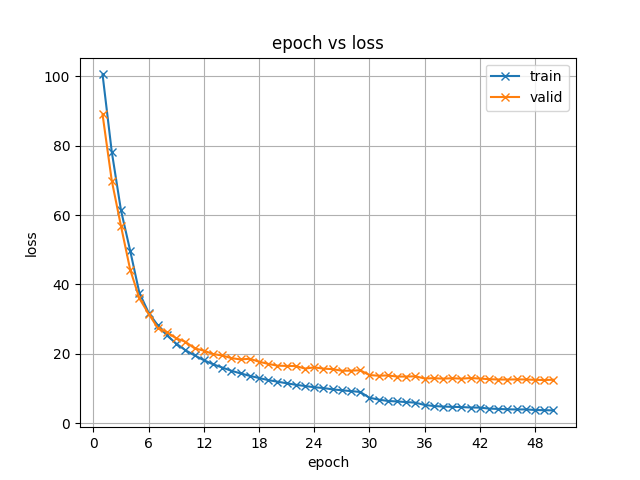

In [15]:
Image(f'exp/{asr_tag}/images/loss.png')

### Learning rate durante o treinamento do modelo

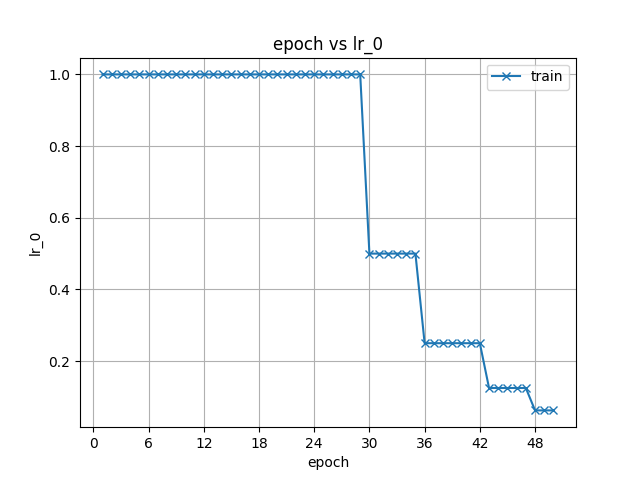

In [16]:
Image(f'exp/{asr_tag}/images/lr_0.png')

## Descrição do modelo

Os módulos do Pytorch usados no modelo, com os respectivos argumentos, são descritos abaixo

In [17]:
asr.model

ESPnetASRModel(
  (frontend): DefaultFrontend(
    (stft): Stft(n_fft=512, win_length=512, hop_length=128, center=True, normalized=False, onesided=True)
    (frontend): Frontend()
    (logmel): LogMel(sr=16000, n_fft=512, n_mels=80, fmin=0, fmax=8000.0, htk=False)
  )
  (specaug): SpecAug(
    (time_warp): TimeWarp(window=5, mode=bicubic)
    (freq_mask): MaskAlongAxis(mask_width_range=[0, 30], num_mask=2, axis=freq)
    (time_mask): MaskAlongAxis(mask_width_range=[0, 40], num_mask=2, axis=time)
  )
  (normalize): GlobalMVN(stats_file=exp/asr_stats_raw_char/train/feats_stats.npz, norm_means=True, norm_vars=True)
  (encoder): RNNEncoder(
    (enc): ModuleList(
      (0): RNNP(
        (birnn0): LSTM(80, 1024, batch_first=True, bidirectional=True)
        (bt0): Linear(in_features=2048, out_features=1024, bias=True)
        (birnn1): LSTM(1024, 1024, batch_first=True, bidirectional=True)
        (bt1): Linear(in_features=2048, out_features=1024, bias=True)
        (birnn2): LSTM(1024, 10

## Camadas do modelo

In [18]:
asr.get_layers()

{'frontend': {'logmel.melmat': torch.Size([257, 80])},
 'specaug': {},
 'normalize': {'mean': torch.Size([80]), 'std': torch.Size([80])},
 'encoder': {'enc.0.birnn0.weight_ih_l0': torch.Size([4096, 80]),
  'enc.0.birnn0.weight_hh_l0': torch.Size([4096, 1024]),
  'enc.0.birnn0.bias_ih_l0': torch.Size([4096]),
  'enc.0.birnn0.bias_hh_l0': torch.Size([4096]),
  'enc.0.birnn0.weight_ih_l0_reverse': torch.Size([4096, 80]),
  'enc.0.birnn0.weight_hh_l0_reverse': torch.Size([4096, 1024]),
  'enc.0.birnn0.bias_ih_l0_reverse': torch.Size([4096]),
  'enc.0.birnn0.bias_hh_l0_reverse': torch.Size([4096]),
  'enc.0.bt0.weight': torch.Size([1024, 2048]),
  'enc.0.bt0.bias': torch.Size([1024]),
  'enc.0.birnn1.weight_ih_l0': torch.Size([4096, 1024]),
  'enc.0.birnn1.weight_hh_l0': torch.Size([4096, 1024]),
  'enc.0.birnn1.bias_ih_l0': torch.Size([4096]),
  'enc.0.birnn1.bias_hh_l0': torch.Size([4096]),
  'enc.0.birnn1.weight_ih_l0_reverse': torch.Size([4096, 1024]),
  'enc.0.birnn1.weight_hh_l0_rever

## Parâmetros mel-fbank (dim=80)

(frontend): DefaultFrontend(

    (stft): Stft(n_fft=512, win_length=512, hop_length=128, center=True, normalized=False, onesided=True)
    
    (frontend): Frontend()
    
    (logmel): LogMel(sr=16000, n_fft=512, n_mels=80, fmin=0, fmax=8000.0, htk=False)
    
 )

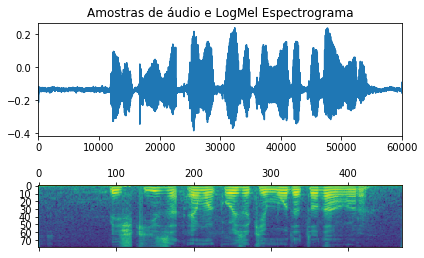

In [19]:

fig, axs = plt.subplots(2, 1)

axs[0].plot(results.audio_samples)
axs[0].set_xlim(xmin=0, xmax=len(results.audio_samples))
axs[0].set_title("Amostras de áudio e LogMel Espectrograma")
axs[1].matshow(results.mel_features[0].T)
fig.tight_layout()

## Specaug

Data augmentation utilizada durante o treinamento, aqui mostrada apenas para visualização.
Máscaras no tempo e na frequência, além de time warping são aplicadas aleatoriamente. É possível executar a célula abaixo várias vezes para visualizar diferentes resultados.

(specaug): [SpecAug](https://arxiv.org/pdf/1904.08779)(

    (time_warp): TimeWarp(window=5, mode=bicubic)
    
    (freq_mask): MaskAlongAxis(mask_width_range=[0, 30], num_mask=2, axis=freq)
    
    (time_mask): MaskAlongAxis(mask_width_range=[0, 40], num_mask=2, axis=time)
    
 )

Text(0.5, 1.05, 'Data Augmentation')

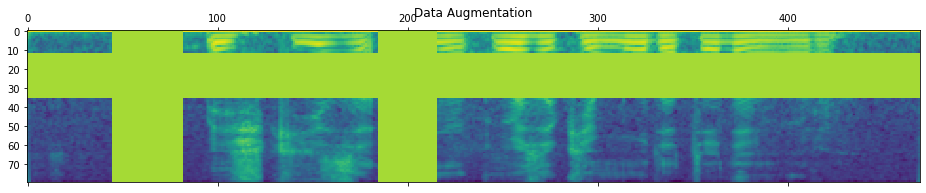

In [20]:
specaug_features,_ = asr.specaug(results.mel_features, results.mel_features.shape[1:])
plt.matshow(specaug_features[0].T)
plt.title("Data Augmentation")
#specaug_features = ASR.model.specaug(results.mel_features, results.mel_features.shape)

## Resultado da camada Encoder

Diferentes redes de encoder fazem diferentes tipos de transformação dos atributos de entrada $\mathbf{X}$. O vetor enc tem diferentes dimensões em cada um deles.

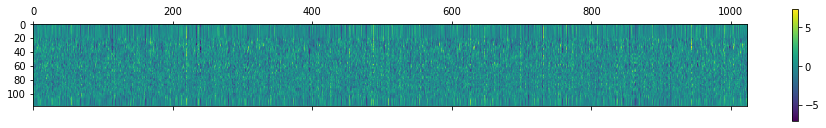

In [21]:
enc = results.encoded_vector
im = plt.matshow(enc.detach().numpy())
plt.colorbar(im)

## Visualização das matrizes de atenção

Cada modelo de atenção possui diferentes subcamadas de atenção, utilize o menu abaixo para selecionar uma delas em cada modelo. O modelo transformer, baseado em Multihea-Attention é treinado com 8 heads mas aqui mostra apenas a primeira delas. Contém as 12 camadas do encoder e as 6 camadas do decoder.

In [22]:
%pylab inline
from ipywidgets import interact, interactive, Layout
def f(x):
    attn = results.attention_weights[x][0]
    if len(attn.shape) == 3:
        attn = attn[0]
    fig, ax = plt.subplots(1, figsize=(10, 5))
    ax.set_title(f"Attention {x}")
    im = ax.matshow(attn, aspect="auto")
    fig.colorbar(im)
    if not 'self_attn' in x or not 'encoder.encoders' in x:
        ax.set_yticks(range(len(results.tokens_txt)))
        ax.set_yticklabels(results.tokens_txt)
    fig.tight_layout()

int_widget = interactive(f, x=list(results.attention_weights.keys()))
#int_widget.children[0].layout = Layout(width='100px')
display(int_widget)

Populating the interactive namespace from numpy and matplotlib


/home/aluca/espnet_ptbr/tools/venv/envs/venv/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


interactive(children=(Dropdown(description='x', options=('decoder.att_list.0',), value='decoder.att_list.0'), …

## Visualização dos CTC Posteriors

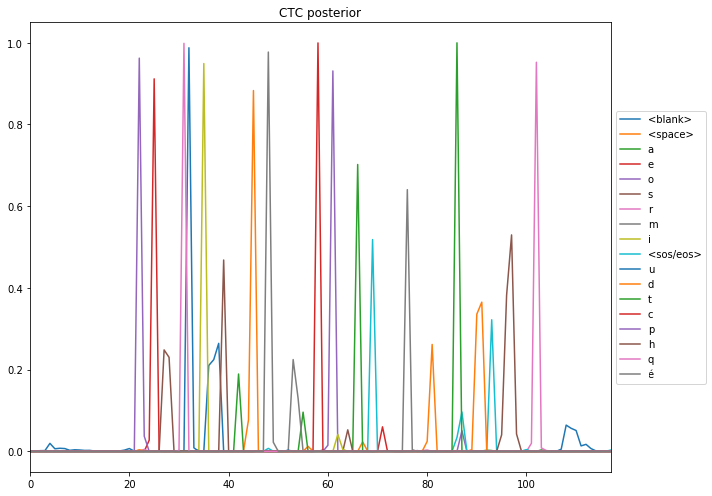

In [23]:
prob = results.ctc_posteriors[0]
fig, ax = plt.subplots(1, figsize=(10, 7))
ax.set_title("CTC posterior")
vs = set(results.tokens_int.tolist())
vs.add(0)
for n, i in enumerate(vs):
    v = asr.converter.ids2tokens([i])[0]
    ax.plot(prob[:, i], label=v)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(0, len(results.encoded_vector)-1)
fig.tight_layout()